In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 2.0,
    'theta': 0.04,
    'xi': 0.1
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

16.0


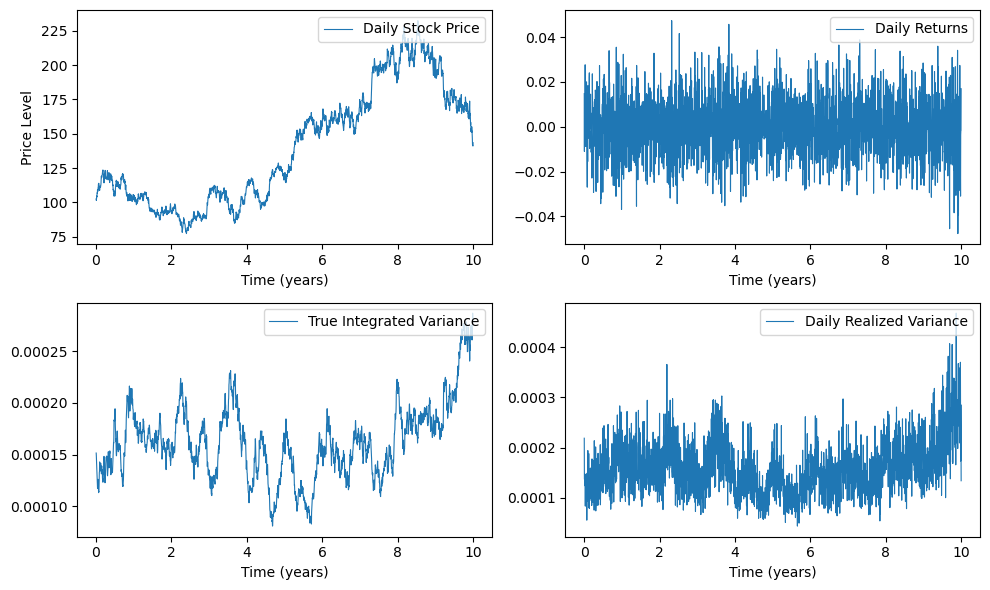

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [6]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.02, 0.00015, 0.001, 0.001, 0.001, -0.4]) # kappa, theta, xi, mu, sigma, rho

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.020000
theta: 0.000150
xi: 0.001000
mu: 0.001000
sigma: 0.001000
rho: -0.400000
Negative Log-Likelihood: -14034.902915
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 2.0e-02  1.5e-04  1.0e-03  1.0e-03  1.0e-03 -4.0e-01]


### Return - Corr

In [7]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.02, 0.00015, 0.00138, 0.0002, -0.5]) # kappa, theta, xi, mu, rho

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.025555
theta: 0.000155
xi: 0.000815
mu: 0.000421
rho: -0.499979
Negative Log-Likelihood: -3739.030282
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 2.55549782e-02  1.55086979e-04  8.14949944e-04  4.21124889e-04
 -4.99978608e-01]


### PF

In [8]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.15),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 487.49354068520375
resampling since: 1194.1834594408035
resampling since: 6657.402780804422
resampling since: 6630.676196188652
resampling since: 648.1334603464344
resampling since: 704.5587284162319
resampling since: 404.49533394397383
resampling since: 1402.5388161449696
resampling since: 3872.8338280757403
resampling since: 192.7567715478526
resampling since: 2662.5463970895894
resampling since: 1032.858920850375
resampling since: 4204.759476071948
resampling since: 2188.2521225530154
resampling since: 1009.967675191537
resampling since: 1134.0140437820733
resampling since: 901.7697474396313
resampling since: 1910.8392100378585
resampling since: 38.56781223292722
resampling since: 5182.373536381007
resampling since: 3117.2272967486483
resampling since: 1057.9587666463926
resampling since: 3874.1586493363898
resampling since: 2049.1337049206873
resampling since: 1898.0254445143814
resampling since: 6498.6375133229
resampling since: 2983.9678297264695
resampling sinc

In [9]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 6175.285882984506
resampling since: 4794.309695816525
resampling since: 6491.968904991331
resampling since: 6751.32092381213
resampling since: 6281.819252789014
resampling since: 6834.549756232253
resampling since: 6870.157948083529
resampling since: 6994.386379819853
resampling since: 6376.502395233499
resampling since: 6902.088725409262
resampling since: 6014.433242877736
resampling since: 6934.025840562613
resampling since: 4793.846295093637
resampling since: 5721.263128084398
resampling since: 5783.139106854637
resampling since: 6058.278201341745
resampling since: 6955.540552593681
resampling since: 4215.673288179766
resampling since: 6854.9149324161035
resampling since: 5462.9569087130885
resampling since: 6704.239428813961
resampling since: 5790.043782263405
resampling since: 6735.554466463851
resampling since: 6835.169157767836
resampling since: 6948.869521382905
resampling since: 6873.418914204402
resampling since: 6442.796091911373
resampling since: 5872.4784

In [10]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [11]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

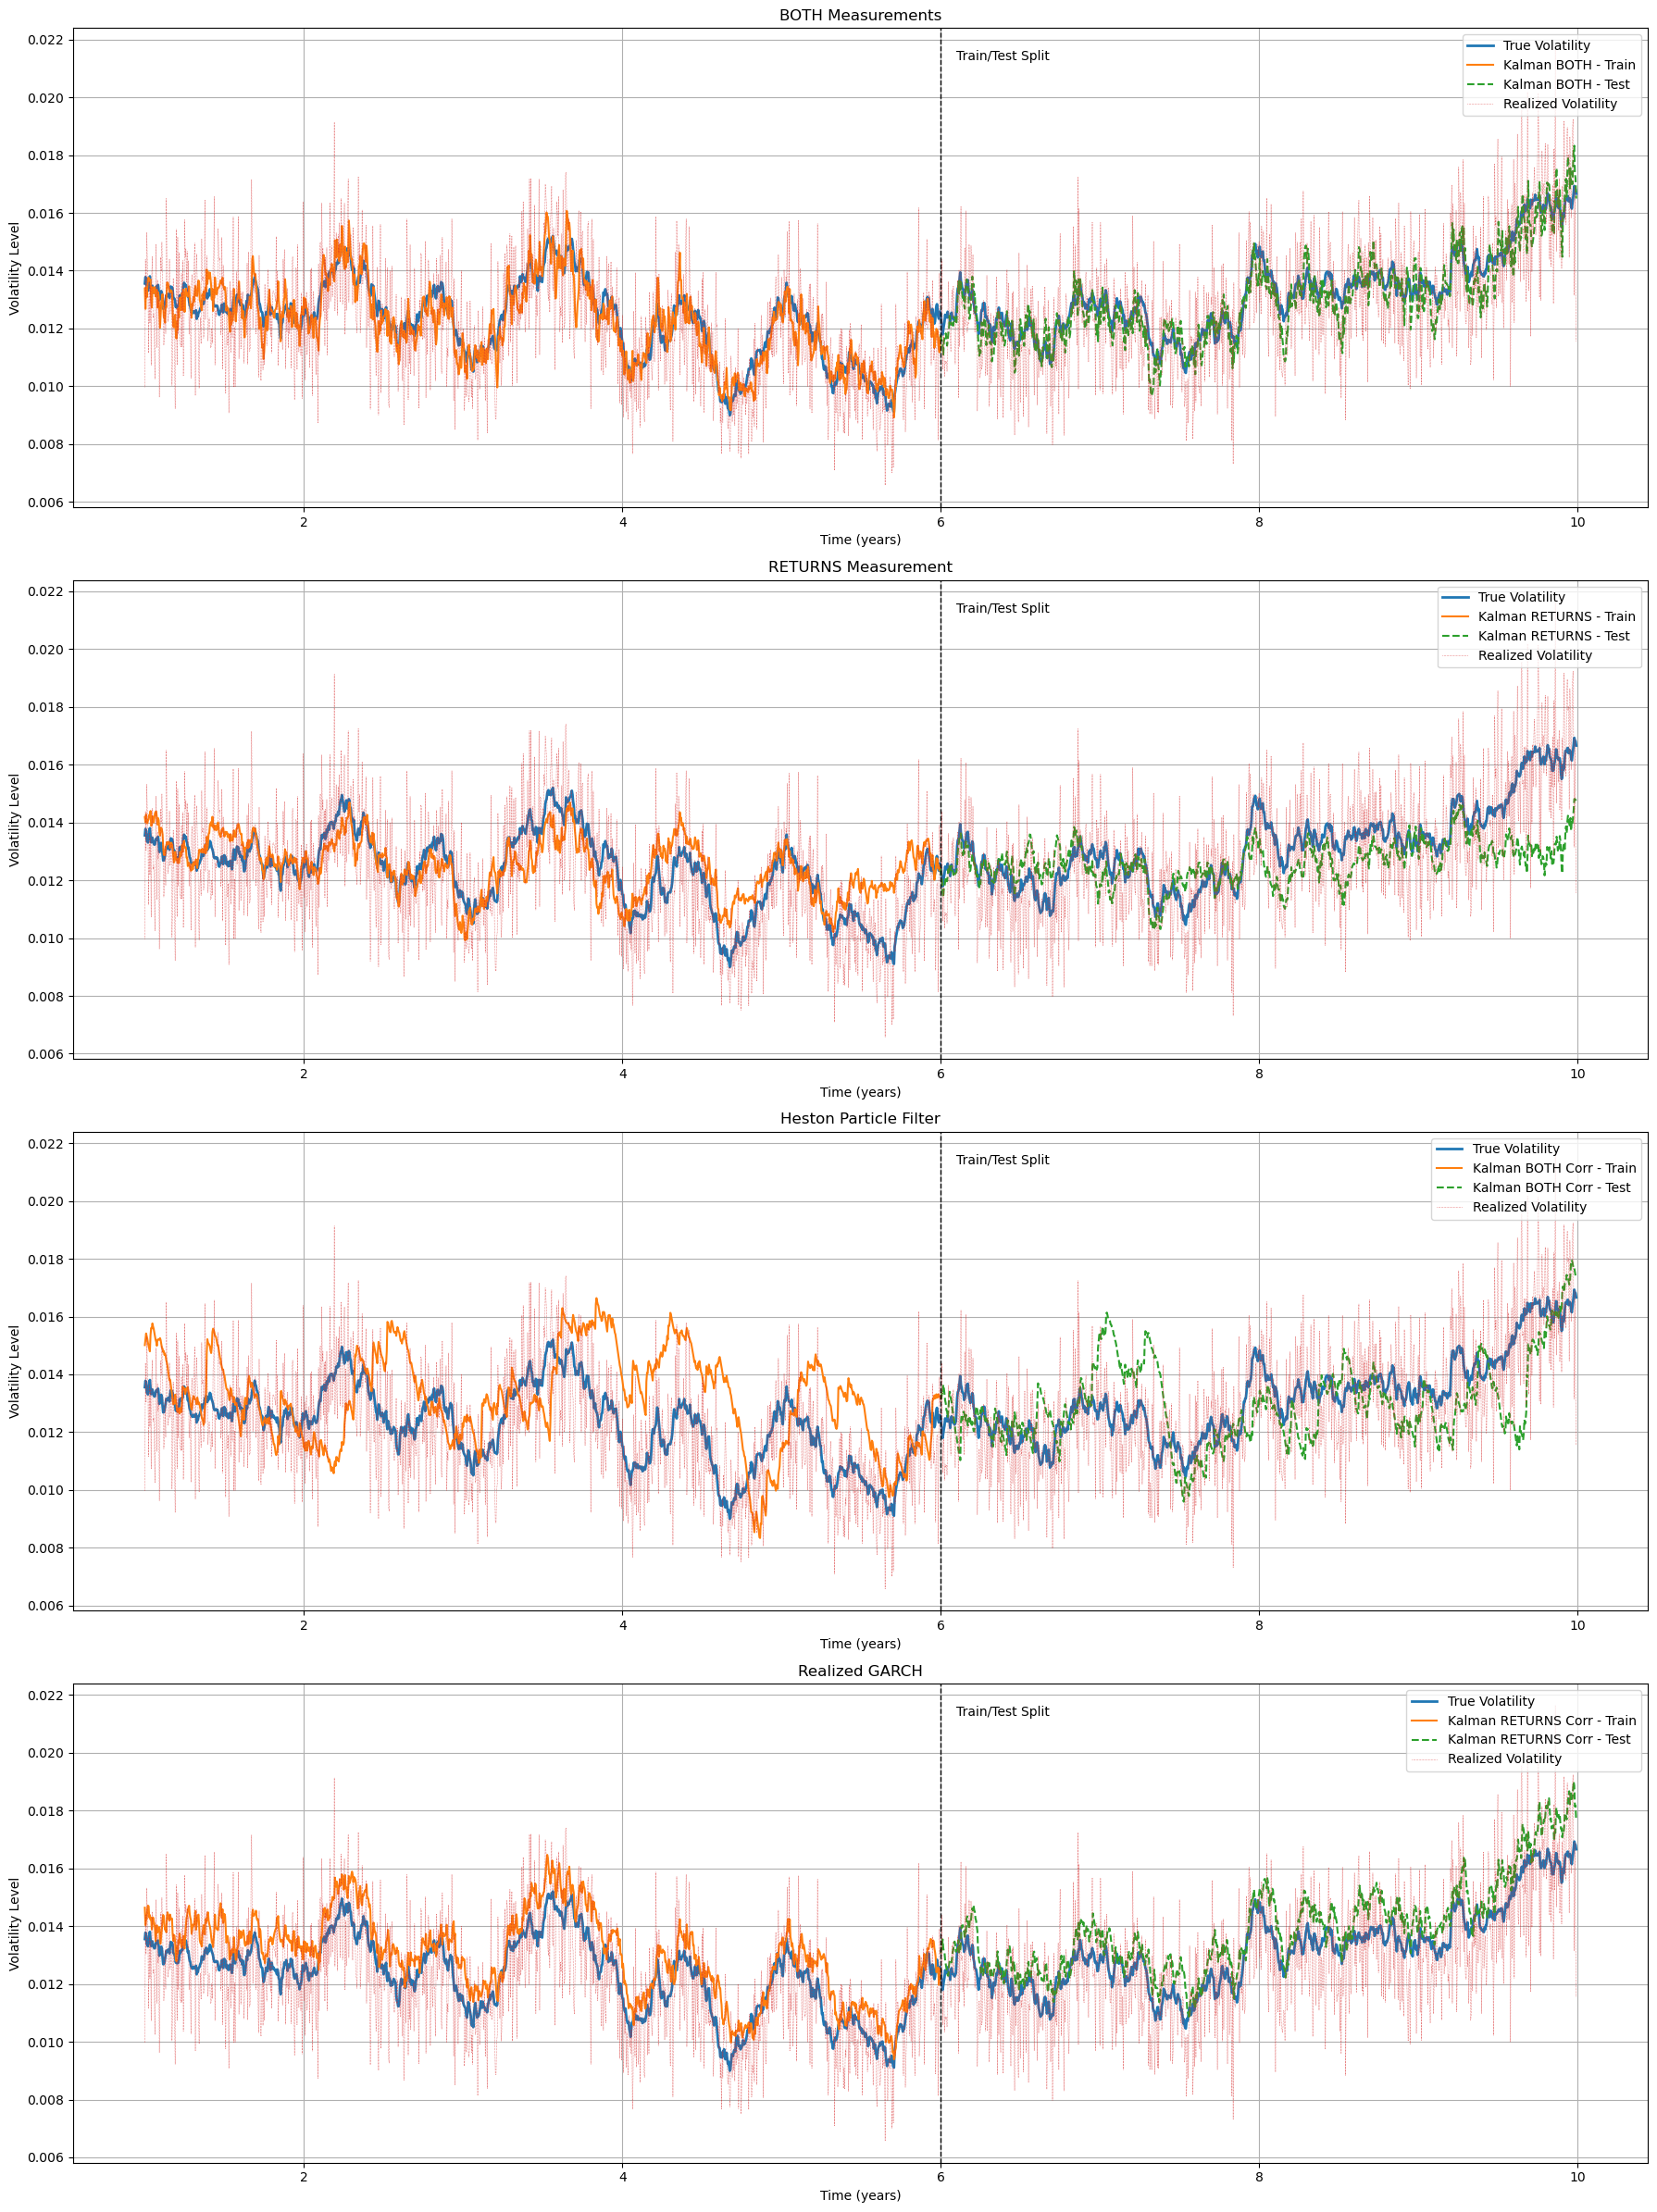

In [12]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/low_vol.png"
)

In [13]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.000583, QLIKE: 0.004227
QLKF               RMSE: 0.001239, QLIKE: 0.017950
PF                 RMSE: 0.001427, QLIKE: 0.023694
Realized GARCH     RMSE: 0.000942, QLIKE: 0.008667


In [14]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,5.0400,6.439854,1.035580
theta,0.0378,0.039082,0.026842
xi,0.2520,0.205367,0.139060
mu,0.2520,0.106123,0.051171
sigma,0.2520,NaN,NaN
rho,-0.4000,-0.499979,-0.200160


In [16]:
pd.Series(dict(zip(model.param_names[:-1], np.round(model.params[:-1], 4))))

omega      0.0158
beta       0.8569
gamma      0.1421
xi        -0.4981
phi        0.9284
tau_1      0.0471
tau_2     -0.0865
sigma_u    0.2811
dtype: float64